In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room,population_per_room
0,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591,0.365909
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797,0.338217
2,-122.26,37.84,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294118,2.026891,0.260274,0.472016
3,-122.26,37.85,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679,0.622321
4,-122.26,37.84,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343675,2.362768,0.203216,0.442162


In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 17515 entries, 0 to 17514
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17515 non-null  float64 
 1   latitude                  17515 non-null  float64 
 2   housing_median_age        17515 non-null  int8    
 3   total_rooms               17515 non-null  int16   
 4   total_bedrooms            17515 non-null  int16   
 5   population                17515 non-null  int16   
 6   households                17515 non-null  int16   
 7   median_income             17515 non-null  float64 
 8   median_house_value        17515 non-null  int32   
 9   ocean_proximity           17515 non-null  category
 10  median_income_cat         17515 non-null  int64   
 11  rooms_per_household       17515 non-null  float64 
 12  population_per_household  17515 non-null  float64 
 13  bedrooms_per_room         17515 non-null  float64 
 14  p

In [4]:
#Definir nossas colunas que serão preprocessadas
coluna_target = ['median_house_value']

coluna_one_hot_encoder = ['ocean_proximity']

coluna_ordinal_encoder = ['median_income_cat']

In [5]:
#Definir X e y
X = df.drop(columns = coluna_target)

y = df[coluna_target]

In [6]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room,population_per_room
0,-122.23,37.88,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591,0.365909
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797,0.338217
2,-122.26,37.84,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294118,2.026891,0.260274,0.472016
3,-122.26,37.85,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679,0.622321
4,-122.26,37.84,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343675,2.362768,0.203216,0.442162


In [7]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


In [10]:
colunas_robust = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder)
colunas_robust

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'population_per_room', 'rooms_per_household', 'total_bedrooms',
       'total_rooms'],
      dtype='str')

In [11]:
colunas_standard = ["longitude","latitude","housing_median_age"]

colunas_power = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder + colunas_standard)
colunas_power

Index(['bedrooms_per_room', 'households', 'median_income', 'population',
       'population_per_household', 'population_per_room',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='str')

In [12]:
#criar o preprocessamento

preprocessamento_cat = ColumnTransformer(
    transformers = [
        ("one_hot_encoder", OneHotEncoder(drop='first'),coluna_one_hot_encoder),
        ("ordinal_encoder", OrdinalEncoder(categories='auto'),coluna_ordinal_encoder),
    ],
    remainder='passthrough',
)


preprocessamento_simples = ColumnTransformer(
    transformers = [
        ("one_hot_encoder", OneHotEncoder(drop='first'),coluna_one_hot_encoder),
        ("ordinal_encoder", OrdinalEncoder(categories='auto'),coluna_ordinal_encoder),
        ("robust", RobustScaler(),colunas_robust),
    ],
)

preprocessamento_completo = ColumnTransformer(
    transformers = [
        ("one_hot_encoder", OneHotEncoder(drop='first'),coluna_one_hot_encoder),
        ("ordinal_encoder", OrdinalEncoder(categories='auto'),coluna_ordinal_encoder),
        ("standard", StandardScaler(), colunas_standard),
        ("power", PowerTransformer(), colunas_power),
    ],
)


In [17]:
param_grid = {
    "regressor__preprocessor": [preprocessamento_cat, preprocessamento_simples, preprocessamento_completo],
    "transformer": [None, PowerTransformer(), QuantileTransformer(output_distribution='normal')]
}

In [18]:
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(),
    param_grid=param_grid,
    preprocessor=preprocessamento_cat,
    target_transformer=PowerTransformer(),
)

grid_search

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",TransformedTa...Transformer())
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'regressor__preprocessor': [ColumnTransfo...ncome_cat'])]), ColumnTransfo...type='str'))]), ...], 'transformer': [None, PowerTransformer(), ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","['r2', 'neg_mean_absolute_error', ...]"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'neg_root_mean_squared_error'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",KFold(n_split... shuffle=True)
,"verbose verbose:

In [19]:
grid_search.fit(X,y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",TransformedTa...Transformer())
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'regressor__preprocessor': [ColumnTransfo...ncome_cat'])]), ColumnTransfo...type='str'))]), ...], 'transformer': [None, PowerTransformer(), ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","['r2', 'neg_mean_absolute_error', ...]"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'neg_root_mean_squared_error'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",KFold(n_split... shuffle=True)
,"verbose verbose:

In [20]:
grid_search.best_params_

{'regressor__preprocessor': ColumnTransformer(transformers=[('one_hot_encoder', OneHotEncoder(drop='first'),
                                  ['ocean_proximity']),
                                 ('ordinal_encoder', OrdinalEncoder(),
                                  ['median_income_cat']),
                                 ('robust', RobustScaler(),
                                  Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
        'longitude', 'median_income', 'population', 'population_per_household',
        'population_per_room', 'rooms_per_household', 'total_bedrooms',
        'total_rooms'],
       dtype='str'))]),
 'transformer': QuantileTransformer(output_distribution='normal')}

In [21]:
grid_search.best_estimator_

,"regressor regressor: object, default=NoneRegressor object such as derived from:class:`~sklearn.base.RegressorMixin`. This regressor willautomatically be cloned each time prior to fitting. If `regressor isNone`, :class:`~sklearn.linear_model.LinearRegression` is created and used.",Pipeline(step...egression())])
,"transformer transformer: object, default=NoneEstimator object such as derived from:class:`~sklearn.base.TransformerMixin`. Cannot be set at the same timeas `func` and `inverse_func`. If `transformer is None` as well as`func` and `inverse_func`, the transformer will be an identitytransformer. Note that the transformer will be cloned during fitting.Also, the transformer is restricting `y` to be a numpy array.",QuantileTrans...tion='normal')
,"func func: function, default=NoneFunction to apply to `y` before passing to :meth:`fit`. Cannot be setat the same time as `transformer`. If `func is None`, the function used will bethe identity function. If `func` is set, `inverse_func` also needs to beprovided. The function needs to return a 2-dimensional array.",None
,"inverse_func inverse_func: function, default=NoneFunction to apply to the prediction of the regressor. Cannot be set atthe same time as `transformer`. The inverse function is used to returnpredictions to the same space of the original training labels. If`inverse_func` is set, `func` also needs to be provided. The inversefunction needs to return a 2-dimensional array.",None
,"check_inverse check_inverse: bool, default=TrueWhether to check that `transform` followed by `inverse_transform`or `func` followed by `inverse_func` leads to the original targets.",True
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('one_hot_encoder', ...), ('ordinal_encoder', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always ret

In [22]:
grid_search.best_estimator_.transformer_

,"n_quantiles n_quantiles: int, default=1000 or n_samplesNumber of quantiles to be computed. It corresponds to the numberof landmarks used to discretize the cumulative distribution function.If n_quantiles is larger than the number of samples, n_quantiles is setto the number of samples as a larger number of quantiles does not givea better approximation of the cumulative distribution functionestimator.",1000
,"output_distribution output_distribution: {'uniform', 'normal'}, default='uniform'Marginal distribution for the transformed data. The choices are'uniform' (default) or 'normal'.",'normal'
,"ignore_implicit_zeros ignore_implicit_zeros: bool, default=FalseOnly applies to sparse matrices. If True, the sparse entries of thematrix are discarded to compute the quantile statistics. If False,these entries are treated as zeros.",False
,"subsample subsample: int or None, default=10_000Maximum number of samples used to estimate the quantiles forcomputational efficiency. Note that the subsampling procedure maydiffer for value-identical sparse and dense matrices.Disable subsampling by setting `subsample=None`... versionadded:: 1.5 The option `None` to disable subsampling was added.",10000
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for subsampling and smoothingnoise.Please see ``subsample`` for more details.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",None
,"copy copy: bool, default=TrueSet to False to perform inplace transformation and avoid a copy (if theinput is already a numpy array).",True


In [38]:
# Definindo noss modelos de treino para comparação

regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    
    "LinearRegression": {
        "preprocessor": preprocessamento_cat,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    
       "LinearRegression_grid_search": {
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    },
}

In [39]:
#Treinar e validar modelos

resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

resultados

{'DummyRegressor': {'fit_time': array([0.00489521, 0.00524545, 0.00495672, 0.00451493, 0.00340629]),
  'score_time': array([0.00543332, 0.0063374 , 0.00520706, 0.00510573, 0.00501347]),
  'test_r2': array([-8.79886502e-04, -7.01292589e-05, -3.90446967e-04, -1.07273469e-04,
         -1.34175423e-04]),
  'test_neg_mean_absolute_error': array([-76256.6430076 , -76449.68322658, -76241.74334592, -77052.4072976 ,
         -77839.12138232]),
  'test_neg_root_mean_squared_error': array([-95147.59926567, -96287.73388159, -95461.5544825 , -96172.37627931,
         -97119.54792537])},
 'LinearRegression': {'fit_time': array([0.02707052, 0.02516484, 0.02373171, 0.02953172, 0.02971292]),
  'score_time': array([0.01278043, 0.01234388, 0.0119679 , 0.02160621, 0.01216674]),
  'test_r2': array([0.69028914, 0.66606835, 0.66104148, 0.6679513 , 0.66398948]),
  'test_neg_mean_absolute_error': array([-39415.65518174, -40876.66288459, -41414.43293308, -40450.64599389,
         -41326.95514596]),
  'test_neg_

In [40]:
#dataframe comparativo com os resultados de tempo e erros dos modelos para cada 'cross-validation'
df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.004895,0.005433,-0.00088,-76256.643008,-95147.599266,0.010329
1,DummyRegressor,0.005245,0.006337,-0.00007,-76449.683227,-96287.733882,0.011583
2,DummyRegressor,0.004957,0.005207,-0.00039,-76241.743346,-95461.554483,0.010164
3,DummyRegressor,0.004515,0.005106,-0.000107,-77052.407298,-96172.376279,0.009621
4,DummyRegressor,0.003406,0.005013,-0.000134,-77839.121382,-97119.547925,0.00842
5,LinearRegression,0.027071,0.01278,0.690289,-39415.655182,-52927.949935,0.039851
6,LinearRegression,0.025165,0.012344,0.666068,-40876.662885,-55639.667647,0.037509
7,LinearRegression,0.023732,0.011968,0.661041,-41414.432933,-55567.007594,0.0357
8,LinearRegression,0.029532,0.021606,0.667951,-40450.645994,-55415.078057,0.051138
9,LinearRegression,0.029713,0.012167,0.663989,-41326.955146,-56292.942964,0.04188


In [41]:
#comparação das médias das métricas por modelo
df_resultados.groupby('model').mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.004604,0.005419,-0.000316,-76767.919652,-96037.762367,0.010023
LinearRegression,0.027042,0.014173,0.669868,-40696.870428,-55168.529239,0.041215
LinearRegression_grid_search,0.04888,0.018193,0.679695,-38587.966615,-54335.606114,0.067073


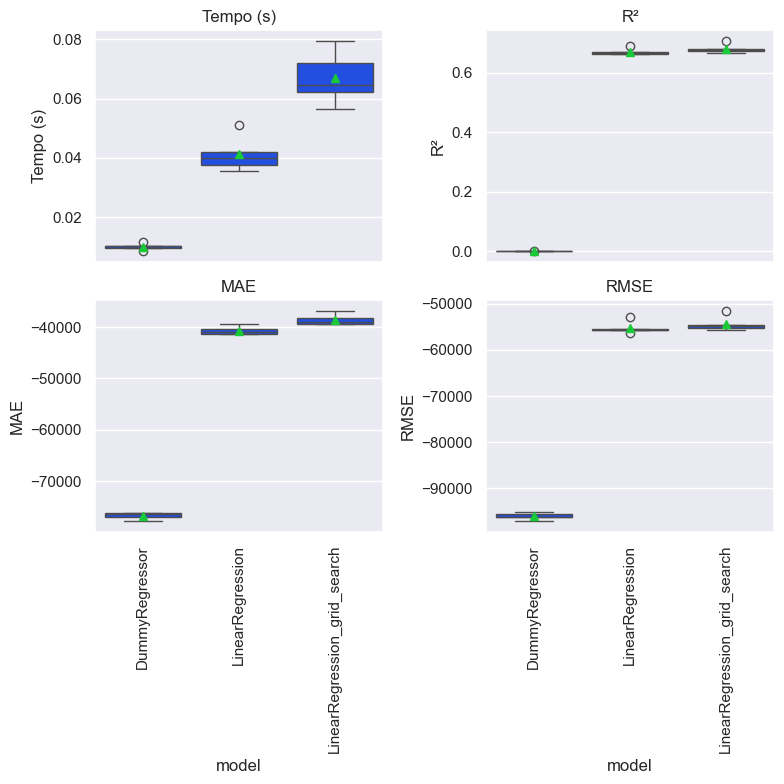

In [43]:
#gráfico comparativos das métricas de cada modelo
plot_comparar_metricas_modelos(df_resultados)

In [44]:
#coeficientes
grid_search.best_estimator_.regressor_['reg'].coef_

array([[-0.44427121, -0.19777033, -0.05650679,  0.03354189,  0.15489239,
         0.2277341 ,  0.11559837, -1.09645938, -1.07977943,  0.78542131,
        -0.04313251, -0.40040857,  0.1926136 ,  0.27354234,  0.00384709,
        -0.12515418]])

In [45]:
#variáveis
grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out()

array(['one_hot_encoder__ocean_proximity_INLAND',
       'one_hot_encoder__ocean_proximity_NEAR BAY',
       'one_hot_encoder__ocean_proximity_NEAR OCEAN',
       'ordinal_encoder__median_income_cat', 'robust__bedrooms_per_room',
       'robust__households', 'robust__housing_median_age',
       'robust__latitude', 'robust__longitude', 'robust__median_income',
       'robust__population', 'robust__population_per_household',
       'robust__population_per_room', 'robust__rooms_per_household',
       'robust__total_bedrooms', 'robust__total_rooms'], dtype=object)

In [46]:
#criando dataframe dos coeficientes
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out()
)

coefs

,coeficiente
robust__latitude,-1.096459
robust__longitude,-1.079779
one_hot_encoder__ocean_proximity_INLAND,-0.444271
robust__population_per_household,-0.400409
one_hot_encoder__ocean_proximity_NEAR BAY,-0.197770
robust__total_rooms,-0.125154
one_hot_encoder__ocean_proximity_NEAR OCEAN,-0.056507
robust__population,-0.043133
robust__total_bedrooms,0.003847
ordinal_encoder__median_income_cat,0.033542


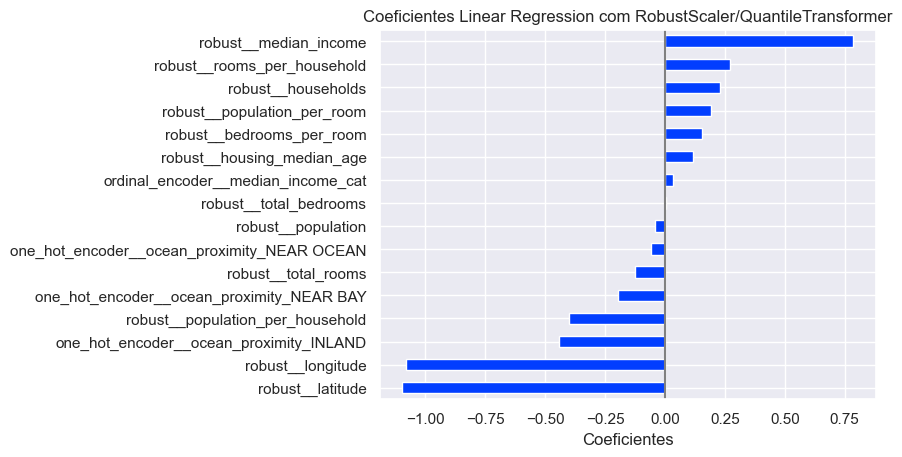

In [49]:
#analise gráfica dos coeficientes do melhor modelo
plot_coeficientes(
    coefs, 
    tituto="Coeficientes Linear Regression com RobustScaler/QuantileTransformer")

Houve grande mudanças no coeficientes devido a normalização da escala dos coeficientes.
Agora agora o modelo valoriza casas em regisão com alta renda e densidade, e com grande quantidade de comodos por domicilios. E penaliza regiões afastada do litoral e com muitas pessoas morando no mesmo domicilio.

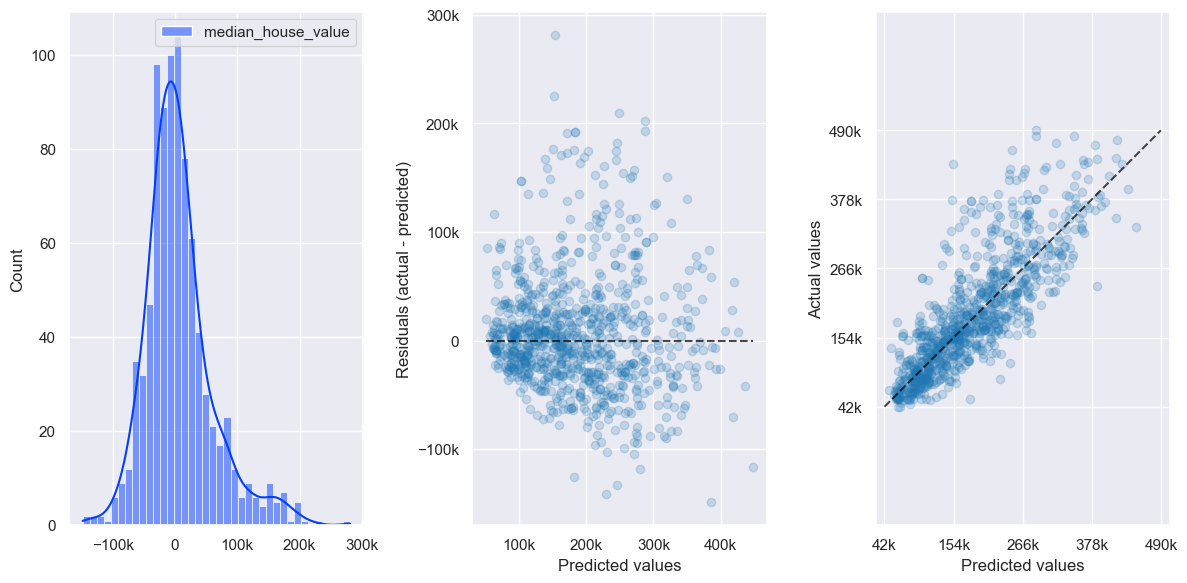

In [48]:
plot_residuos_estimador(
    grid_search.best_estimator_, 
    X, 
    y,
    fracao_amostra=0.05,
    eng_formatter=True
)

O grágico de resíduos mostra que o Modelo consegue prever os valor medio das casas com pequeno erro para a maior parte dos valores. E o modelo tem mais erros para uma valor menor que o valor real.